In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import os
import sys
import warnings

from sympy import use

warnings.simplefilter('ignore')

sys.path.append('../utilities')
sys.path.append('../models/grt123')
sys.path.append('../models/grt123/training')
sys.path.append('../models/grt123/preprocessing/')

# from layers import nms,iou
from summit_utils import *
from evaluation import noduleCADEvaluation

workspace_path = os.path.join(os.getcwd(), '..')

LUNA_EXCLUSIONS_PATH = Path(f'{workspace_path}/data/LUNA/metadata/annotations_excluded.csv')
LUNA_GRT_EXCLUSIONS = Path(f'{workspace_path}/data/LUNA/metadata/grt123_annotations_excluded.csv')


exclude_recode = {
    'seriesuid' : 'name',
    'coordX' : 'row',
    'coordY' : 'col',
    'coordZ' : 'index',
    'diameter_mm' : 'diameter'
}

# GRT 123 - Trained LUNA Evaluated on LUNA

## Utility functions

In [16]:
def get_scans_path(scans_path, working_path, folds=True):

    if folds:
        scans_paths = Path(scans_path).rglob('**/validation_scans.csv')
        scan_ids = pd.concat([pd.read_csv(scan_path) for scan_path in scans_paths]).scan_id
    else:
        scan_ids = pd.read_csv(scans_path).scan_id

    scan_ids.to_csv(working_path / 'scanlist.csv', index=False)
    return working_path / 'scanlist.csv'


def get_annotations_path(metadata_path, working_path, recode={}):
    metadata = pd.read_csv(metadata_path).rename(columns=recode)
    metadata.to_csv(working_path / 'annotations.csv', index=False)
    return working_path / 'annotations.csv'

def get_predictions_path(predictions_path, working_path, recode={}, threshold=None):

    Path(working_path).mkdir(parents=True, exist_ok=True)

    predictions = pd.read_csv(predictions_path).rename(columns=recode)
    if threshold:
        predictions = predictions[predictions['threshold'] > threshold]
    predictions.to_csv(working_path / 'predictions.csv', index=False)
    return working_path / 'predictions.csv'


def get_exclusions_path(exclusions_path, working_path, recode={}):
    exclusions = pd.read_csv(exclusions_path).rename(columns=recode)
    exclusions.to_csv(working_path / 'exclusions.csv', index=False)
    return working_path / 'exclusions.csv'

def get_threshold_at_8fpps(metrics, cut_off=8):
    fps = metrics[0]
    sens = metrics[1]
    threshold = metrics[2]

    false_positives_per_scan_range = [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]
    cut_off_id = false_positives_per_scan_range.index(cut_off)

    idxs = []
    fps_values = []
    sens_values = []
    thresh_values = []
    for fpps in false_positives_per_scan_range:

        idx = np.abs(fps - fpps).argmin()
        idxs.append(idx)
        fps_values.append(fps[idx])
        sens_values.append(sens[idx])
        thresh_values.append(threshold[idx])

    print('False Positives Operating Points:', false_positives_per_scan_range)
    print('False Positives per Scan:', fps_values)
    print('Sensitivity:', sens_values)
    print('Threshold:', thresh_values)

    print('Threshold at 8 FPPS:', thresh_values[cut_off_id])
    return thresh_values[cut_off_id]

## Arm 1: Balanced combination of Positive and Negative samples

/home/jmccabe/Projects/SOTAEvaluationNoduleDetection/notebooks/../results/grt123/trained_luna/luna/arm1/annotations.csv
Total number of included nodule annotations: 1186
Total number of nodule annotations: 36378
Cases: 889
computing FROC: bootstrap 0/1000
computing FROC: bootstrap 1/1000
computing FROC: bootstrap 2/1000
computing FROC: bootstrap 3/1000
computing FROC: bootstrap 4/1000
computing FROC: bootstrap 5/1000
computing FROC: bootstrap 6/1000
computing FROC: bootstrap 7/1000
computing FROC: bootstrap 8/1000
computing FROC: bootstrap 9/1000
computing FROC: bootstrap 10/1000
computing FROC: bootstrap 11/1000
computing FROC: bootstrap 12/1000
computing FROC: bootstrap 13/1000
computing FROC: bootstrap 14/1000
computing FROC: bootstrap 15/1000
computing FROC: bootstrap 16/1000
computing FROC: bootstrap 17/1000
computing FROC: bootstrap 18/1000
computing FROC: bootstrap 19/1000
computing FROC: bootstrap 20/1000
computing FROC: bootstrap 21/1000
computing FROC: bootstrap 22/1000
compu

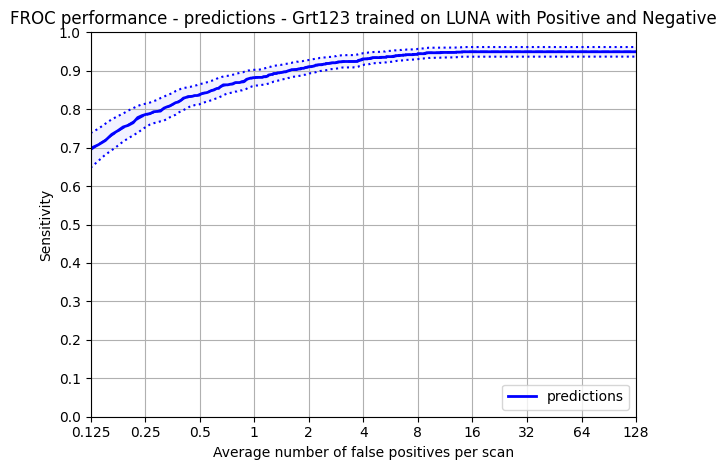

In [3]:
results_path = Path(f'{workspace_path}/results/grt123/trained_luna/luna/arm1')

scans_path = get_scans_path(
    Path(f'{workspace_path}/metadata/luna/arm1'),
    results_path,
    folds=True
)

annotations_path = get_annotations_path(
    Path(f'{workspace_path}/models/grt123/bbox_result/trained_luna/luna/arm1/arm1_metadata.csv'),
    results_path
)

predictions_path = get_predictions_path(
    Path(f'{workspace_path}/models/grt123/bbox_result/trained_luna/luna/arm1/arm1_predictions.csv'),
    results_path
)

exclusions_path = get_exclusions_path(
    LUNA_GRT_EXCLUSIONS,
    results_path,
)

grt123_luna_on_luna_arm1 = noduleCADEvaluation(
    annotations_filename=annotations_path,
    annotations_excluded_filename=exclusions_path,
    seriesuids_filename=scans_path,
    results_filename=predictions_path,    
    filter='Grt123 trained on LUNA with Positive and Negative',
    outputDir=f'{workspace_path}/results/grt123/trained_luna/luna/arm1',
)

False Positives Operating Points: [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]
False Positives per Scan: [0.12485939257592801, 0.24746906636670415, 0.49943757030371205, 1.015748031496063, 1.9842519685039368, 3.9595050618672665, 7.995500562429696, 14.094488188976378, 14.094488188976378, 14.094488188976378, 14.094488188976378]
Sensitivity: [0.6964586846543002, 0.7858347386172007, 0.8381112984822934, 0.8819561551433389, 0.9097807757166948, 0.9300168634064081, 0.9435075885328836, 0.9494097807757167, 0.9494097807757167, 0.9494097807757167, 0.9494097807757167]
Threshold: [5.590331, 5.108508, 4.5284595, 3.8143363, 2.788436, 1.3970709, 0.12122488, -0.9999039, -0.9999039, -0.9999039, -0.9999039]
/home/jmccabe/Projects/SOTAEvaluationNoduleDetection/notebooks/../results/grt123/trained_luna/luna/arm1/annotations.csv
Total number of included nodule annotations: 1186
Total number of nodule annotations: 36378
Cases: 889


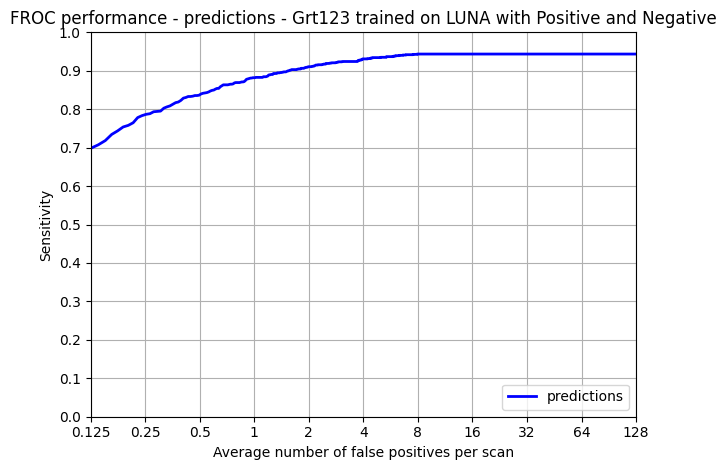

In [4]:
threshold_at_8fpps = get_threshold_at_8fpps(grt123_luna_on_luna_arm1)
results_path = results_path / '8fpps'

predictions_path = get_predictions_path(
    Path(f'{workspace_path}/models/grt123/bbox_result/trained_luna/luna/arm1/arm1_predictions.csv'),
    results_path,
    threshold=threshold_at_8fpps
)

grt123_luna_on_luna_arm1 = noduleCADEvaluation(
    annotations_filename=annotations_path,
    annotations_excluded_filename=exclusions_path,
    seriesuids_filename=scans_path,
    results_filename=predictions_path,
    outputDir=f'{workspace_path}/results/grt123/trained_luna/luna/arm1/8fpps',    
    filter='Grt123 trained on LUNA with Positive and Negative',
    perform_bootstrapping=False
)

## Arm 2: Trained with just Positive samples

/home/jmccabe/Projects/SOTAEvaluationNoduleDetection/notebooks/../results/grt123/trained_luna/luna/arm2/annotations.csv
Total number of included nodule annotations: 1186
Total number of nodule annotations: 36378
Cases: 889
computing FROC: bootstrap 0/1000
computing FROC: bootstrap 1/1000
computing FROC: bootstrap 2/1000
computing FROC: bootstrap 3/1000
computing FROC: bootstrap 4/1000
computing FROC: bootstrap 5/1000
computing FROC: bootstrap 6/1000
computing FROC: bootstrap 7/1000
computing FROC: bootstrap 8/1000
computing FROC: bootstrap 9/1000
computing FROC: bootstrap 10/1000
computing FROC: bootstrap 11/1000
computing FROC: bootstrap 12/1000
computing FROC: bootstrap 13/1000
computing FROC: bootstrap 14/1000
computing FROC: bootstrap 15/1000
computing FROC: bootstrap 16/1000
computing FROC: bootstrap 17/1000
computing FROC: bootstrap 18/1000
computing FROC: bootstrap 19/1000
computing FROC: bootstrap 20/1000
computing FROC: bootstrap 21/1000
computing FROC: bootstrap 22/1000
compu

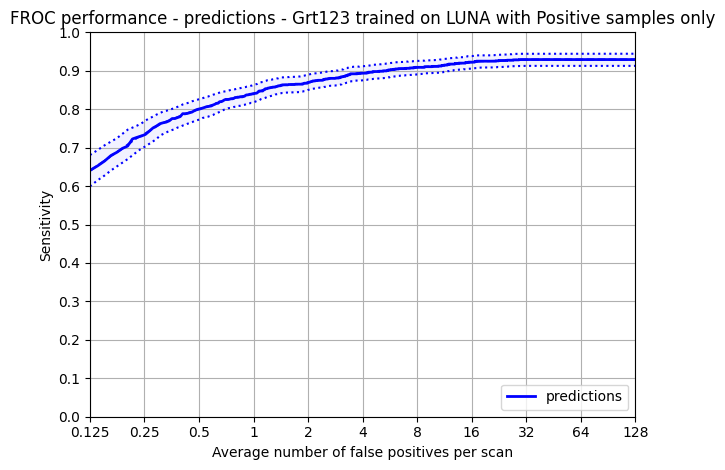

In [5]:
# arm 2

results_path = Path(f'{workspace_path}/results/grt123/trained_luna/luna/arm2')

scans_path = get_scans_path(
    Path(f'{workspace_path}/metadata/luna/arm1'),
    results_path,
)

annotations_path = get_annotations_path(
    Path(f'{workspace_path}/models/grt123/bbox_result/trained_luna/luna/arm2/arm2_metadata.csv'),
    results_path
)

predictions_path = get_predictions_path(
    Path(f'{workspace_path}/models/grt123/bbox_result/trained_luna/luna/arm2/arm2_predictions.csv'),
    results_path
)

exclusions_path = get_exclusions_path(
    LUNA_GRT_EXCLUSIONS,
    results_path,
)

grt123_luna_on_luna_arm2 = noduleCADEvaluation(
    annotations_filename=annotations_path,
    annotations_excluded_filename=exclusions_path,
    seriesuids_filename=scans_path,
    results_filename=predictions_path,    
    filter='Grt123 trained on LUNA with Positive samples only',
    outputDir=f'{workspace_path}/results/grt123/trained_luna/luna/arm2',
)

False Positives Operating Points: [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]
False Positives per Scan: [0.12598425196850394, 0.24971878515185603, 0.49606299212598426, 1.0056242969628795, 1.9865016872890888, 3.8830146231721034, 7.769403824521935, 16.3644544431946, 29.280089988751406, 29.280089988751406, 29.280089988751406]
Sensitivity: [0.6408094435075885, 0.7335581787521079, 0.8001686340640809, 0.839797639123103, 0.8684654300168634, 0.8929173693086003, 0.9080944350758853, 0.9224283305227656, 0.9291736930860034, 0.9291736930860034, 0.9291736930860034]
Threshold: [5.8985605, 5.4483304, 4.9285016, 4.368787, 3.6529315, 2.7252157, 1.5178208, 0.08552933, -0.9999578, -0.9999578, -0.9999578]
/home/jmccabe/Projects/SOTAEvaluationNoduleDetection/notebooks/../results/grt123/trained_luna/luna/arm2/annotations.csv
Total number of included nodule annotations: 1186
Total number of nodule annotations: 36378
Cases: 889


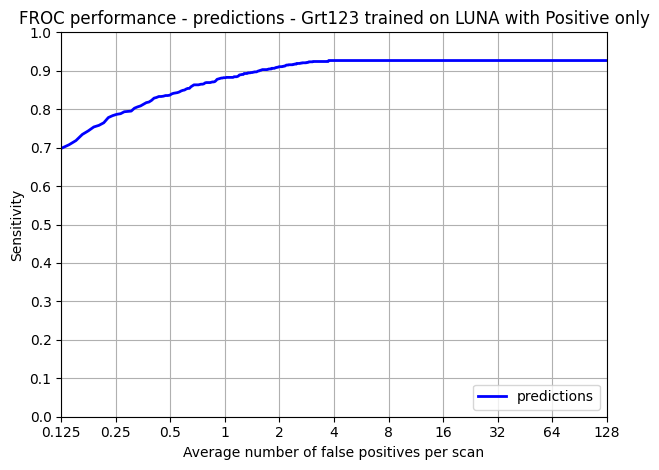

In [6]:
threshold_at_8fpps = get_threshold_at_8fpps(grt123_luna_on_luna_arm2)
results_path = results_path / '8fpps'

predictions_path = get_predictions_path(
    Path(f'{workspace_path}/models/grt123/bbox_result/trained_luna/luna/arm1/arm1_predictions.csv'),
    results_path,
    threshold=threshold_at_8fpps
)

grt123_luna_on_luna_arm2_fpps8 = noduleCADEvaluation(
    annotations_filename=annotations_path,
    annotations_excluded_filename=exclusions_path,
    seriesuids_filename=scans_path,
    results_filename=predictions_path,
    outputDir=f'{workspace_path}/results/grt123/trained_luna/luna/arm2/8fpps',    
    filter='Grt123 trained on LUNA with Positive only',
    perform_bootstrapping=False
)

# GRT 123 Trained LUNA Evaluated on SUMMIT

## Inference Using Arm1 - Positive & Negative Training Samples

/home/jmccabe/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/grt123/bbox_result/trained_luna/summit/partial/arm1/metadata.csv
Total number of included nodule annotations: 1082
Total number of nodule annotations: 1292
Cases: 798
computing FROC: bootstrap 0/1000
computing FROC: bootstrap 1/1000
computing FROC: bootstrap 2/1000
computing FROC: bootstrap 3/1000
computing FROC: bootstrap 4/1000
computing FROC: bootstrap 5/1000
computing FROC: bootstrap 6/1000
computing FROC: bootstrap 7/1000
computing FROC: bootstrap 8/1000
computing FROC: bootstrap 9/1000
computing FROC: bootstrap 10/1000
computing FROC: bootstrap 11/1000
computing FROC: bootstrap 12/1000
computing FROC: bootstrap 13/1000
computing FROC: bootstrap 14/1000
computing FROC: bootstrap 15/1000
computing FROC: bootstrap 16/1000
computing FROC: bootstrap 17/1000
computing FROC: bootstrap 18/1000
computing FROC: bootstrap 19/1000
computing FROC: bootstrap 20/1000
computing FROC: bootstrap 21/1000
computing FROC: bootst

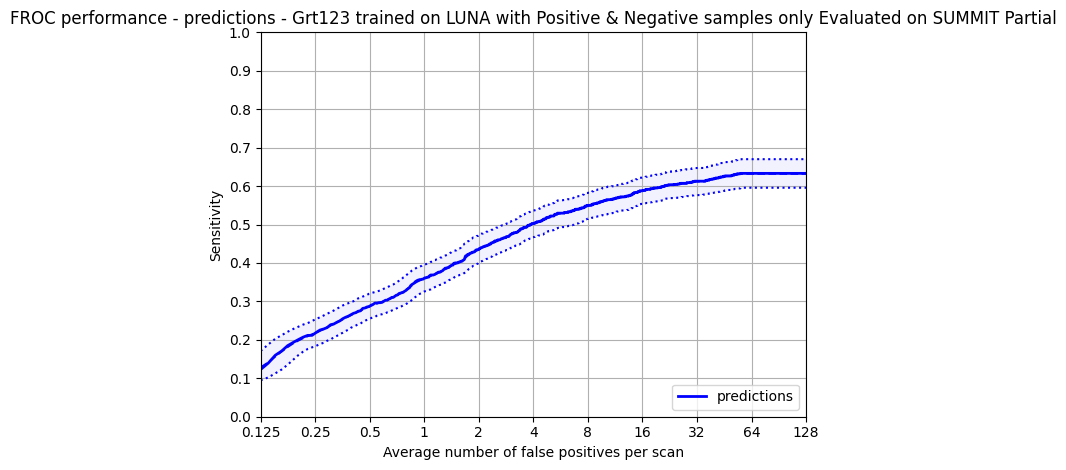

In [22]:
results_path = Path(f'{workspace_path}/results/grt123/trained_luna/summit/partial/arm1')

scans_path = f"{workspace_path}/metadata/summit/partial/test_scans.csv"

annotations_path = f"{workspace_path}/models/grt123/bbox_result/trained_luna/summit/partial/arm1/metadata.csv"

exclusions_path = f"{workspace_path}/models/grt123/prep_result/summit/exclusions/exclusions.csv"

predictions_path = f"{workspace_path}/models/grt123/bbox_result/trained_luna/summit/partial/arm1/predictions.csv"

grt123_luna_on_summit_partial_arm1 = noduleCADEvaluation(
    annotations_filename=annotations_path,
    annotations_excluded_filename=exclusions_path,
    seriesuids_filename=scans_path,
    results_filename=predictions_path,    
    filter='Grt123 trained on LUNA with Positive & Negative samples only Evaluated on SUMMIT Partial',
    outputDir=results_path,
)

False Positives Operating Points: [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]
False Positives per Scan: [0.12531328320802004, 0.2506265664160401, 0.49749373433583965, 1.0025062656641603, 2.0050125313283207, 4.048872180451128, 7.9298245614035086, 16.071428571428573, 31.914786967418546, 58.31578947368421, 58.31578947368421]
Sensitivity: [0.12292051756007394, 0.21626617375231053, 0.28650646950092423, 0.36044362292051757, 0.43530499075785584, 0.5027726432532348, 0.5489833641404805, 0.5878003696857671, 0.6127541589648798, 0.633086876155268, 0.633086876155268]
Threshold: [6.5888047, 6.040241, 5.578257, 5.094361, 4.5447755, 3.8412623, 2.9673562, 1.6411023, -0.0027813911, -0.9999862, -0.9999862]
Threshold at 8 FPPS: 2.9673562
/home/jmccabe/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/grt123/bbox_result/trained_luna/summit/partial/arm1/metadata.csv
Total number of included nodule annotations: 1082
Total number of nodule annotations: 1292
Cases: 798


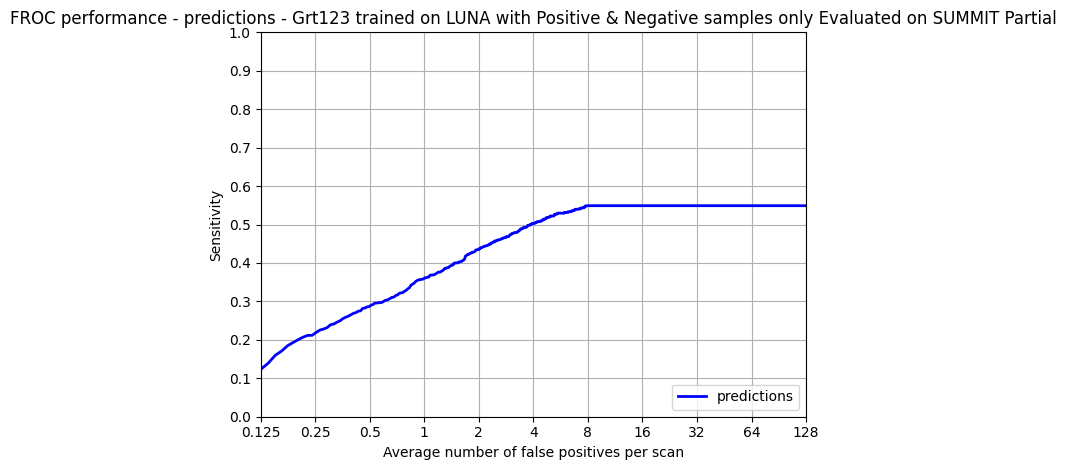

In [25]:
results_path = Path(f'{workspace_path}/results/grt123/trained_luna/summit/partial/arm1')

threshold_at_8fpps = get_threshold_at_8fpps(grt123_luna_on_summit_partial_arm1)
results_path = results_path / '8fpps'

results_path.mkdir(parents=True, exist_ok=True)

predictions = pd.read_csv(predictions_path)
predictions_at_fpps8 = predictions[predictions['threshold'] > threshold_at_8fpps]
predictions_at_fpps8.to_csv(results_path / 'predictions.csv', index=False)


grt123_luna_on_summit_partial_arm1_fpps8 = noduleCADEvaluation(
    annotations_filename=annotations_path,
    annotations_excluded_filename=exclusions_path,
    seriesuids_filename=scans_path,
    results_filename=results_path / 'predictions.csv',
    outputDir=results_path,    
    filter='Grt123 trained on LUNA with Positive & Negative samples only Evaluated on SUMMIT Partial',
    perform_bootstrapping=False
)

## Inference Using Arm2 - Positive & Negative Training Samples

In [ ]:

scans_path = f"{workspace_path}/metadata/summit/partial/test_scans.csv"

annotations_path = f"{workspace_path}/models/grt123/bbox_result/trained_luna/summit/partial/arm1/metadata.csv"

exclusions_path = f"{workspace_path}/models/grt123/prep_result/summit/exclusions/exclusions.csv"

predictions_path = f"{workspace_path}/models/grt123/bbox_result/trained_luna/summit/partial/arm2/predictions.csv"

grt123_luna_on_summit_partial_arm2 = noduleCADEvaluation(
    annotations_filename=annotations_path,
    annotations_excluded_filename=exclusions_path,
    seriesuids_filename=scans_path,
    results_filename=predictions_path,    
    filter='Grt123 trained on LUNA with Positive & Negative samples only Evaluated on SUMMIT Partial',
    outputDir=f'{workspace_path}/results/grt123/trained_luna/summit/partial/arm2',
)

# Detection - Trained LUNA Evaluated LUNA

## Utility functions

In [ ]:

def iou(box0, box1):
    r0 = box0[3] / 2
    s0 = box0[:3] - r0
    e0 = box0[:3] + r0

    r1 = box1[3] / 2
    s1 = box1[:3] - r1
    e1 = box1[:3] + r1

    overlap = []
    for i in range(len(s0)):
        overlap.append(max(0, min(e0[i], e1[i]) - max(s0[i], s1[i])))

    intersection = overlap[0] * overlap[1] * overlap[2]
    union = box0[3] * box0[3] * box0[3] + box1[3] * box1[3] * box1[3] - intersection
    return intersection / union

def nms(predictions, overlap_threshold=0.1):
    """
    Non-maximum suppression

    Args:
    predictions (pd.DataFrame): dataframe of predictions
    overlap_threshold (float): threshold for overlap

    Returns:
    nms_predictions (pd.DataFrame): dataframe of nms predictions
    
    """

    nms_predictions = pd.DataFrame(columns=predictions.columns)

    while len(predictions) > 0:
        max_idx = predictions['threshold'].idxmax()
        max_row = predictions.loc[max_idx]

        nms_predictions = nms_predictions.append(max_row)

        predictions = predictions.drop(max_idx)

        for idx, row in predictions.iterrows():
            
            overlap = iou(
                    max_row[['row', 'col', 'index', 'diameter']].values, 
                    row[['row', 'col', 'index', 'diameter']].values
                )
            
            if overlap > overlap_threshold:
                predictions = predictions.drop(idx)

    return nms_predictions

def get_scans_path(metadata_csv_path, results_dir, recode={}):
    scans_list = []
    for scans_path in metadata_csv_path.rglob('validation_scans.csv'):
        scans_list.append(pd.read_csv(scans_path))

    scans = pd.concat(scans_list, ignore_index=True)
    print('Number of scans:',scans.shape)

    scans_filepath = results_dir / 'scanlist.csv'
    scans.to_csv(scans_filepath, index=False)

    return scans.scan_id, scans_filepath    

def get_annotations_path(metadata_csv_path, results_dir, recode={}):
    """
    Convert metadata to annotation file

    Args:
    metadata_csv_path (str): path to metadata csv
    scan_ids (list): list of scan ids
    results_dir (str): path to results directory
    recode (dict): dictionary to rename columns

    Returns:
    annotations_filepath (str): path to annotations csv
    
    """

    annotations_list = []
    
    for metadata_csv_path in metadata_csv_path.rglob('validation_annotations.csv'):
        annotations_list.append(pd.read_csv(metadata_csv_path).rename(columns=recode))

    annotations = pd.concat(annotations_list, ignore_index=True)
    print('Number of nodules:',annotations.shape)

    annotations_filepath = results_dir / 'annotations.csv'
    annotations.to_csv(annotations_filepath, index=False)

    return annotations_filepath

def get_exclusions_path(metadata_csv_path, scan_ids, results_dir, recode={}):
    """
    Convert metadata to exclusion file

    Args:
    metadata_csv_path (str): path to metadata csv
    scan_ids (list): list of scan ids
    results_dir (str): path to results directory
    recode (dict): dictionary to rename columns

    Returns:
    exclusions_filepath (str): path to exclusions csv
    
    """

    exclusions = pd.read_csv(metadata_csv_path).rename(columns=recode)
    exclusions = exclusions[exclusions['name'].isin(scan_ids)]

    exclusions_filepath = results_dir / 'exclusions.csv'
    exclusions.to_csv(exclusions_filepath, index=False)

    return exclusions_filepath

def combine_predictions(predictions_json_path, results_dir, dataset_name, use_nms=True):
    """
    Get predictions from a json file

    Args:
    predictions_json_path: str, path to the json file

    Returns:
    images: list of str, list of image names
    predictions: pd.DataFrame, dataframe of predictions
    
    """
    predictions_list = []

    for prediction_json_path in predictions_json_path.glob('*json'):
        
        print(prediction_json_path)

        with open(prediction_json_path,'r') as f:
            predictions_json = json.load(f)

        idx = 0
        for image_cnt, image in enumerate(predictions_json[dataset_name]):
            name = image['image'].split('/')[-1][:-7]
            
            image_predictions_dict = {}
            for box, score in zip(image['box'], image['score']):
                prediction = {}
                prediction['threshold'] = score
                prediction['index'] = box[2]
                prediction['col'] = box[1]
                prediction['row'] = box[0]
                prediction['diameter'] = np.max(box[3:])
                prediction['name'] = name

                image_predictions_dict[idx] = prediction
                idx+=1
            
            image_predictions = pd.DataFrame.from_dict(image_predictions_dict, orient='index')
            if image_cnt == 0 and use_nms:
                print(image_predictions.shape)
                print('after nms')
                print(nms(image_predictions).shape)

            if use_nms:
                predictions_list.append(nms(image_predictions))
            else:
                predictions_list.append(image_predictions)

    predictions = pd.concat(predictions_list, ignore_index=True)
    predictions.to_csv(results_dir / 'predictions.csv', index=False)

    return results_dir / 'predictions.csv'


## Arm 1: Balanced combination of Positive and Negative samples

In [ ]:
results_output_path = Path(f'{workspace_path}/results/detection/trained_luna/luna/arm1')
results_output_path.mkdir(parents=True, exist_ok=True)

model_results_path  = Path(f'{workspace_path}/models/detection/result/trained_luna/LUNA/arm1')
model_results_path.mkdir(parents=True, exist_ok=True)


scan_ids, scanlist_filepath = get_scans_path(
                            metadata_csv_path=Path(f'{workspace_path}/metadata/luna/arm1'),
                            results_dir=model_results_path
                        )


annotations_filepath = get_annotations_path(
                            metadata_csv_path=Path(f'{workspace_path}/metadata/luna/arm1'),
                            results_dir=model_results_path,
                            recode=exclude_recode
                        )

exclusions_filepath = get_exclusions_path(
                            metadata_csv_path=LUNA_EXCLUSIONS_PATH,
                            scan_ids=scan_ids,
                            results_dir=model_results_path,
                            recode=exclude_recode
                        )

predictions_filepath = combine_predictions(
                            predictions_json_path=Path(model_results_path),
                            results_dir=model_results_path,
                            dataset_name='test',
                            use_nms=False
                        )

detection_luna_on_luna_arm1 = noduleCADEvaluation(
    annotations_filename=annotations_filepath,
    annotations_excluded_filename=exclusions_filepath,
    seriesuids_filename=scanlist_filepath,
    results_filename=predictions_filepath,    
    filter='Detection trained on LUNA with Positive and Negative',
    outputDir=results_output_path
)

## Arm 2: Trained with just Positive samples

In [ ]:
results_output_path = Path(f'{workspace_path}/results/detection/trained_luna/luna/arm2')
results_output_path.mkdir(parents=True, exist_ok=True)

model_results_path  = Path(f'{workspace_path}/models/detection/result/trained_luna/LUNA/arm2')
model_results_path.mkdir(parents=True, exist_ok=True)


scan_ids, scanlist_filepath = get_scans_path(
                            metadata_csv_path=Path(f'{workspace_path}/metadata/luna/arm1'),
                            results_dir=model_results_path
                        )


annotations_filepath = get_annotations_path(
                            metadata_csv_path=Path(f'{workspace_path}/metadata/luna/arm1'),
                            results_dir=model_results_path,
                            recode=exclude_recode
                        )

exclusions_filepath = get_exclusions_path(
                            metadata_csv_path=LUNA_EXCLUSIONS_PATH,
                            scan_ids=scan_ids,
                            results_dir=model_results_path,
                            recode=exclude_recode
                        )

predictions_filepath = combine_predictions(
                            predictions_json_path=Path(model_results_path),
                            results_dir=model_results_path,
                            dataset_name='test',
                            use_nms=False
                        )

detection_luna_on_luna_arm2 = noduleCADEvaluation(
    annotations_filename=annotations_filepath,
    annotations_excluded_filename=exclusions_filepath,
    seriesuids_filename=scanlist_filepath,
    results_filename=predictions_filepath,    
    filter='Detection trained on LUNA with Positive only',
    outputDir=results_output_path
)

# Detection - Trained LUNA evaluated on SUMMIT

In [39]:
from numpy import rec


def get_summit_scans_path(scanlist_filepath, working_path, folds=True):
    """
    Get scans path for summit

    Args:
    scanlist_filepath (str): path to scanlist csv
    working_path (str): path to working directory
    folds (bool): whether to use folds

    Returns:
    scans_path (str): path to scans csv
    
    """

    scan_ids = pd.read_csv(scanlist_filepath).scan_id

    scan_ids.to_csv(working_path / 'scanlist.csv', index=False)
    return working_path / 'scanlist.csv'

def get_summit_annotations_path(annotations_filepath, working_path, recode={}):
    """
    Get annotations path for summit

    Args:
    annotations_filepath (str): path to annotations csv
    working_path (str): path to working directory
    recode (dict): dictionary to rename columns

    Returns:
    annotations_path (str): path to annotations csv
    
    """

    annotations = (
        pd.read_csv(annotations_filepath)
        .rename(columns=recode)
        .assign(threshold=-1000000)
        .assign(scan_id=lambda df: df.participant_id + '_Y0_BASELINE_A')
    ).rename(columns=recode)

    annotations.to_csv(working_path / 'annotations.csv', index=False)

    return working_path / 'annotations.csv'


def get_summit_exclusions_path(exclusions_filepath, working_path, recode={}):
    """
    Get exclusions path for summit

    Args:
    exclusions_filepath (str): path to exclusions csv
    working_path (str): path to working directory
    recode (dict): dictionary to rename columns

    Returns:
    exclusions_path (str): path to exclusions csv
    
    """

    exclusions = (
        pd.read_csv(exclusions_filepath)
        .rename(columns=recode)
        .assign(threshold=-1000000)
        .assign(scan_id=lambda df: df.participant_id + '_Y0_BASELINE_A')
    ).rename(columns=recode)

    exclusions.to_csv(working_path / 'exclusions.csv', index=False)

    return working_path / 'exclusions.csv'

def get_summit_predictions_path_from_json(results_json_path, working_path, threshold=None):
    """
    Get predictions path for summit

    Args:
    results_json_path (str): path to results json
    working_path (str): path to working directory
    recode (dict): dictionary to rename columns

    Returns:
    predictions_path (str): path to predictions csv
    
    """

    with open(results_json_path,'r') as f:
        predictions_json = json.load(f)

    idx = 0

    image_predictions_dict = {}
    for image in predictions_json['test']:
        name = image['image'].split('/')[-1][:-7]

        for box, score in zip(image['box'], image['score']):
            prediction = {}
            prediction['threshold'] = score
            prediction['index'] = box[2]
            prediction['col'] = box[1]
            prediction['row'] = box[0]
            prediction['diameter'] = np.max(box[3:])
            prediction['name'] = name

            image_predictions_dict[idx] = prediction
            idx+=1
        
    predictions = pd.DataFrame.from_dict(image_predictions_dict, orient='index')

    if threshold:
        predictions = predictions[predictions['threshold'] > threshold]

    predictions.to_csv(working_path / 'predictions.csv', index=False)

    return working_path / 'predictions.csv'

/home/jmccabe/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/trained_luna/SUMMIT/partial/annotations.csv
Total number of included nodule annotations: 1082
Total number of nodule annotations: 1292
Cases: 798
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-5729-yex_Y0_BASELINE_A, nodule Annot ID: None
computing FROC: bootstrap 0/1000
computing FROC: bootstrap 1/1000
computing FROC: bootstrap 2/1000
computing FROC: bootstrap 3/1000
computing FROC: bootstrap 4/1000
computing FROC: bootstrap 5/1000
computing FROC: bootstrap 6/1000
computing FROC: bootstrap 7/1000
computing FROC: bootstrap 8/1000
computing FROC: bootstrap 9/1000
computing FROC: bootstrap 10/1000
computing FROC: bootstrap 11/1000
computing FROC: bootstrap 12/1000
computing FROC: bootstrap 13/1000
computing FROC: bootstrap 14/1000
computing FROC: bootstrap 15/1000
computing FROC: bootstrap 16/1000
computing FROC: bootstrap 17/1000
com

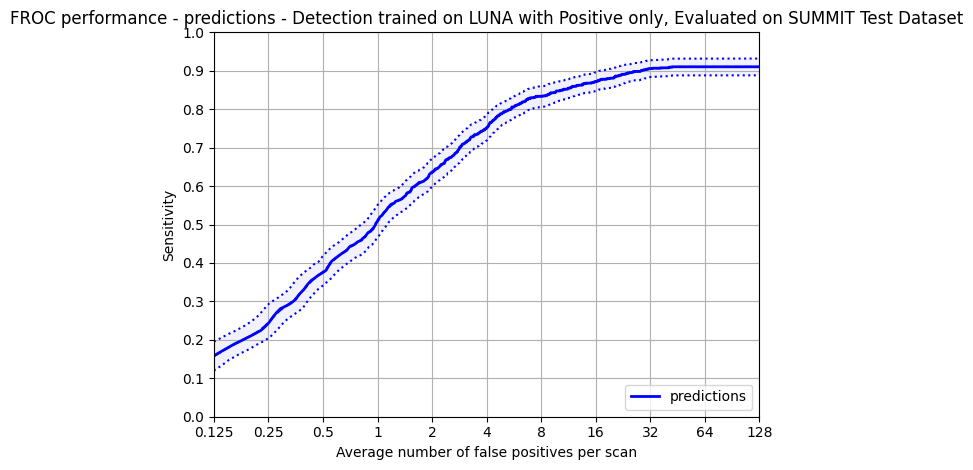

In [67]:
results_output_path = Path(f'{workspace_path}/results/detection/trained_luna/summit/partial')
results_output_path.mkdir(parents=True, exist_ok=True)


metadata_recode = {
        'scan_id':'name',
        'nodule_x_coordinate':'row',
        'nodule_y_coordinate':'col',
        'nodule_z_coordinate':'index',
        'nodule_diameter_mm':'diameter'
}

scanlist_filepath = get_summit_scans_path(Path(f'{workspace_path}/metadata/summit/partial/test_scans.csv'),
                                   Path(f'{workspace_path}/models/detection/result/trained_luna/SUMMIT/partial'))

annotations_filepath = get_summit_annotations_path(Path(f'{workspace_path}/metadata/summit/partial/test_metadata.csv'),
                                                   Path(f'{workspace_path}/models/detection/result/trained_luna/SUMMIT/partial'),
                                                   recode=metadata_recode)

exclusions_filepath = get_summit_exclusions_path(Path(f'{workspace_path}/metadata/summit/partial/test_excludes.csv'),
                                                Path(f'{workspace_path}/models/detection/result/trained_luna/SUMMIT/partial'),
                                                recode=metadata_recode)

predictions_filepath = get_summit_predictions_path_from_json(Path(f'{workspace_path}/models/detection/result/trained_luna/SUMMIT/partial/result_partial.json'),
                                                             Path(f'{workspace_path}/models/detection/result/trained_luna/SUMMIT/partial'))

detection_luna_on_summit_partial = noduleCADEvaluation(
    annotations_filename=annotations_filepath,
    annotations_excluded_filename=exclusions_filepath,
    seriesuids_filename=scanlist_filepath,
    results_filename=predictions_filepath,    
    filter='Detection trained on LUNA with Positive only, Evaluated on SUMMIT Test Dataset',
    outputDir=results_output_path
)



False Positives Operating Points: [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]
False Positives per Scan: [0.12656641604010024, 0.2518796992481203, 0.4949874686716792, 0.993734335839599, 2.0025062656641603, 3.9974937343358397, 7.99749373433584, 15.999999999999998, 31.99749373433584, 46.28947368421053, 46.28947368421053]
Sensitivity: [0.16081330868761554, 0.24491682070240295, 0.37430683918669133, 0.5073937153419593, 0.6367837338262476, 0.7513863216266173, 0.833641404805915, 0.8715341959334566, 0.9057301293900185, 0.910351201478743, 0.910351201478743]
Threshold: [0.99853515625, 0.99658203125, 0.9912109375, 0.97607421875, 0.93115234375, 0.77587890625, 0.38427734375, 0.09686279296875, 0.0300445556640625, 0.02001953125, 0.02001953125]
Threshold at 8 FPPS: 0.38427734375
/home/jmccabe/Projects/SOTAEvaluationNoduleDetection/notebooks/../models/detection/result/trained_luna/SUMMIT/partial/annotations.csv
Total number of included nodule annotations: 1082
Total number of nodule annotations: 129

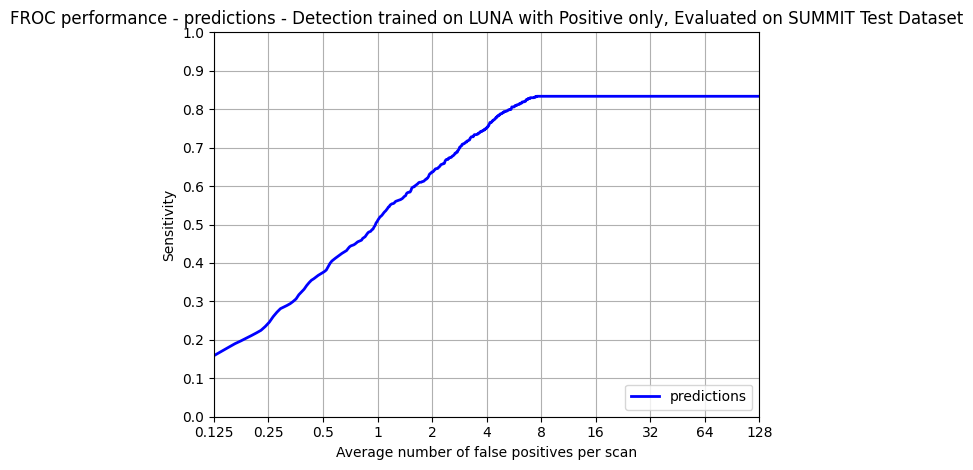

In [40]:
results_output_path = Path(f'{workspace_path}/results/detection/trained_luna/summit/partial')
threshold_at_8fpps = get_threshold_at_8fpps(detection_luna_on_summit_partial)
results_output_path = results_output_path / '8fpps'

results_output_path.mkdir(parents=True, exist_ok=True)

predictions_filepath = get_summit_predictions_path_from_json(Path(f'{workspace_path}/models/detection/result/trained_luna/SUMMIT/partial/result_partial.json'),
                                                             Path(f'{workspace_path}/models/detection/result/trained_luna/SUMMIT/partial'),
                                                             threshold=threshold_at_8fpps)

grt123_luna_on_luna_arm1 = noduleCADEvaluation(
    annotations_filename=annotations_filepath,
    annotations_excluded_filename=exclusions_filepath,
    seriesuids_filename=scanlist_filepath,
    results_filename=predictions_filepath,
    outputDir=results_output_path,    
    filter='Detection trained on LUNA with Positive only, Evaluated on SUMMIT Test Dataset',
    perform_bootstrapping=False
)

In [ ]:
fps = grt123_luna_on_luna_arm1[0]
tpr = grt123_luna_on_luna_arm1[1]
thresholds = grt123_luna_on_luna_arm1[2]


idx = []
fp = []
th  = []
for rate in [0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]:
    absolute_differences = np.abs(fps - rate)
    closest_index = np.argmin(absolute_differences)
    idx.append(closest_index)
    th.append(thresholds[closest_index])
    fp.append(fps[closest_index])

print(idx)
print(fp)
print(th)

# Miss Analysis

## Utility functions

In [ ]:
fps = grt123_luna_on_summit_partial_arm1[0]
sens = grt123_luna_on_summit_partial_arm1[1]
threshold = grt123_luna_on_summit_partial_arm1[2]

false_positives_per_scan_range = [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]

idxs = []
fps_values = []
sens_values = []
thresh_values = []
for fpps in false_positives_per_scan_range:

    idx = np.abs(fps - fpps).argmin()
    idxs.append(idx)
    fps_values.append(fps[idx])
    sens_values.append(sens[idx])
    thresh_values.append(threshold[idx])

print('False Positives Operating Points:', false_positives_per_scan_range)
print('False Positives per Scan:', fps_values)
print('Sensitivity:', sens_values)
print('Threshold:', thresh_values)

predictions = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_luna/summit/partial/arm1/predictions.csv')
misses = predictions[predictions.threshold < thresh_values[6]]

print(len(misses))

In [26]:
grt123_misses = (
    pd.read_csv(f'{workspace_path}/results/grt123/trained_luna/summit/partial/arm1/8fpps/nodulesWithoutCandidate_predictions.txt', header=None)
    .rename(columns={0:'name',
                     1:'idx',
                     2:'col',
                     3:'row',
                     4:'index',
                     5:'diameter',
                     6:'threshold'})
    .assign(miss=True)
    .assign(index=lambda df: df['index'].astype(int))
    .assign(row=lambda df: df['row'].astype(int))
    .assign(col=lambda df: df['col'].astype(int))
    .assign(diameter=lambda df: df['diameter'].astype(int))
)

display(grt123_misses.shape)

metadata = (
    pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_luna/summit/partial/arm1/metadata.csv')
    .assign(index=lambda df: df['index'].astype(int))
    .assign(row=lambda df: df['row'].astype(int))
    .assign(col=lambda df: df['col'].astype(int))
    .assign(diameter=lambda df: df['diameter'].astype(int))
)

grt123_misses = metadata.merge(grt123_misses, on=['name','index','row','col','diameter'], how='left')
grt123_misses.miss.fillna(False, inplace=True)
grt123_misses.nodule_type.replace({'CALCIFIED': 'CONSOLIDATION'}, inplace=True)
grt123_misses = grt123_misses[~grt123_misses.radiology_report_lesions_to_exclude]
display(grt123_misses.miss.value_counts())


(488, 8)

miss
False    594
True     488
Name: count, dtype: int64

In [41]:
detection_misses = (
    pd.read_csv(f'{workspace_path}/results/detection/trained_luna/summit/partial/8fpps/nodulesWithoutCandidate_predictions.txt', header=None)
    .rename(columns={0:'name',
                     1:'idx',
                     2:'col',
                     3:'row',
                     4:'index',
                     5:'diameter',
                     6:'threshold'})
    .assign(index=lambda df: df['index'].astype(int))
    .assign(row=lambda df: df['row'].astype(int))
    .assign(col=lambda df: df['col'].astype(int))
    .assign(diameter=lambda df: df['diameter'].astype(int))                     
    .assign(miss=True)
)


metadata = (
    pd.read_csv(f'{workspace_path}/metadata/summit/partial/test_metadata.csv')
    .assign(index=lambda df: df['nodule_z_coordinate'].astype(int))
    .assign(row=lambda df: df['nodule_x_coordinate'].astype(int))
    .assign(col=lambda df: df['nodule_y_coordinate'].astype(int))
    .assign(diameter=lambda df: df['nodule_diameter_mm'].astype(int))
    .assign(name=lambda df: df['participant_id'] + '_Y0_BASELINE_A')
)

salient_vars = ['name','index','row','col','diameter']

detection_misses = metadata.merge(detection_misses, on=['name','index','row','col','diameter'], how='left')
detection_misses.miss.fillna(False, inplace=True)
detection_misses.nodule_type.replace({'CALCIFIED': 'CONSOLIDATION'}, inplace=True)
detection_misses = detection_misses[~detection_misses.radiology_report_lesions_to_exclude]

display(detection_misses.miss.value_counts())

miss
False    902
True     180
Name: count, dtype: int64

********************************************************************************
nodule_type
********************************************************************************


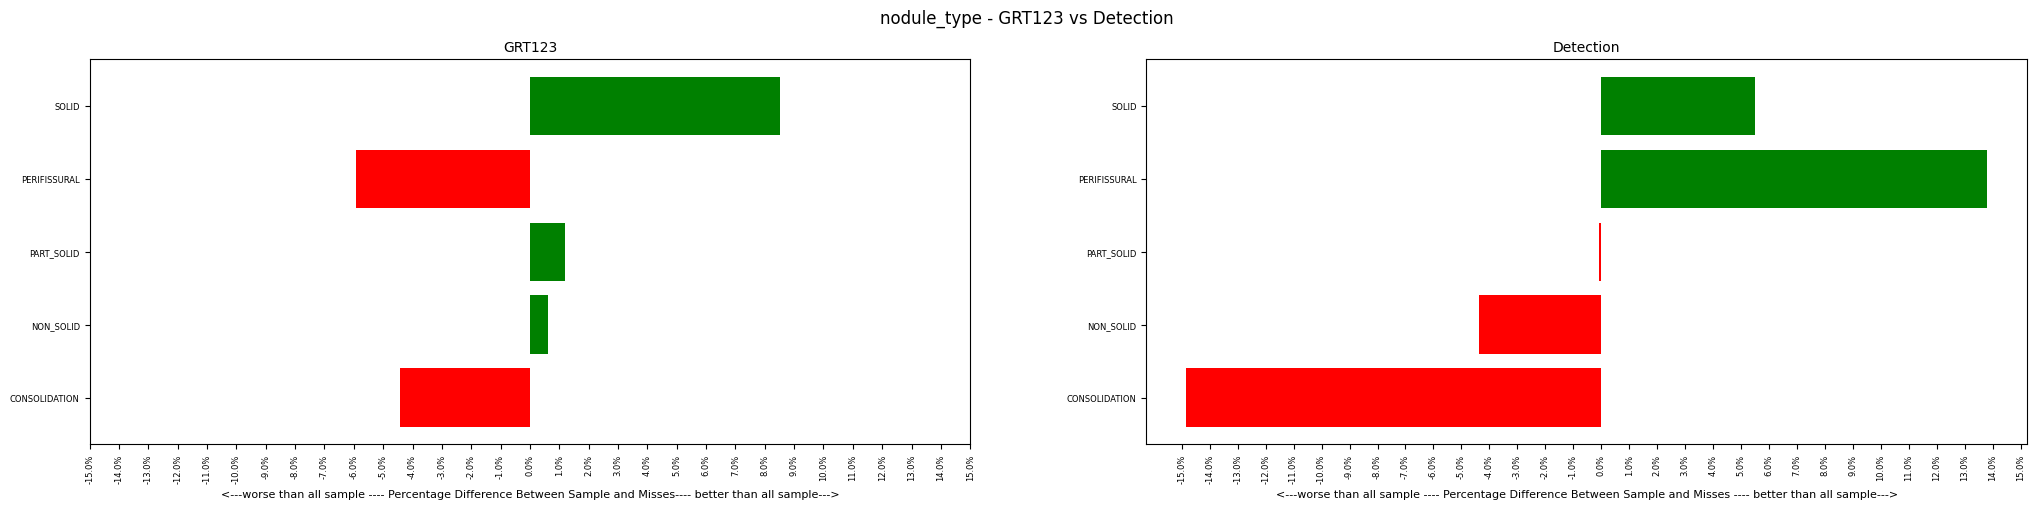

********************************************************************************
nodule_lung_rads
********************************************************************************


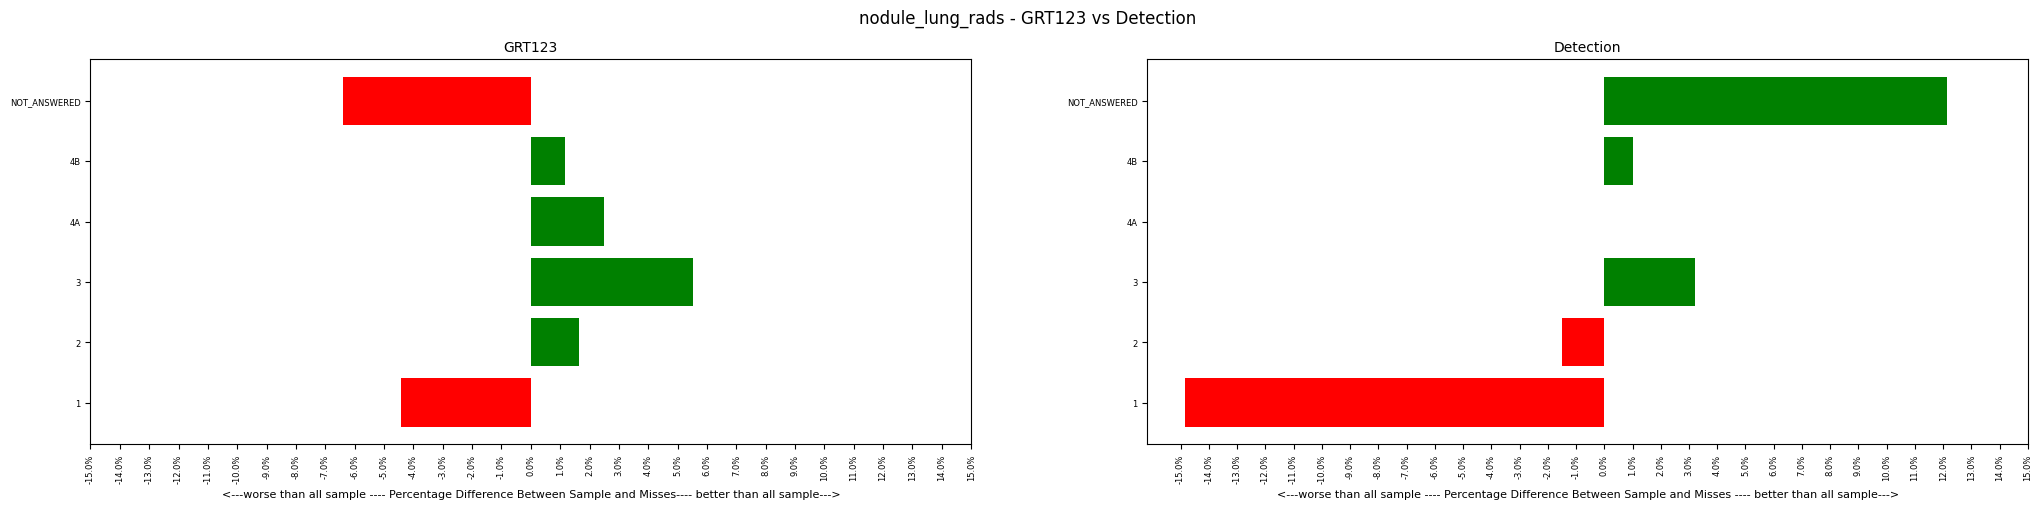

********************************************************************************
nodule_site
********************************************************************************


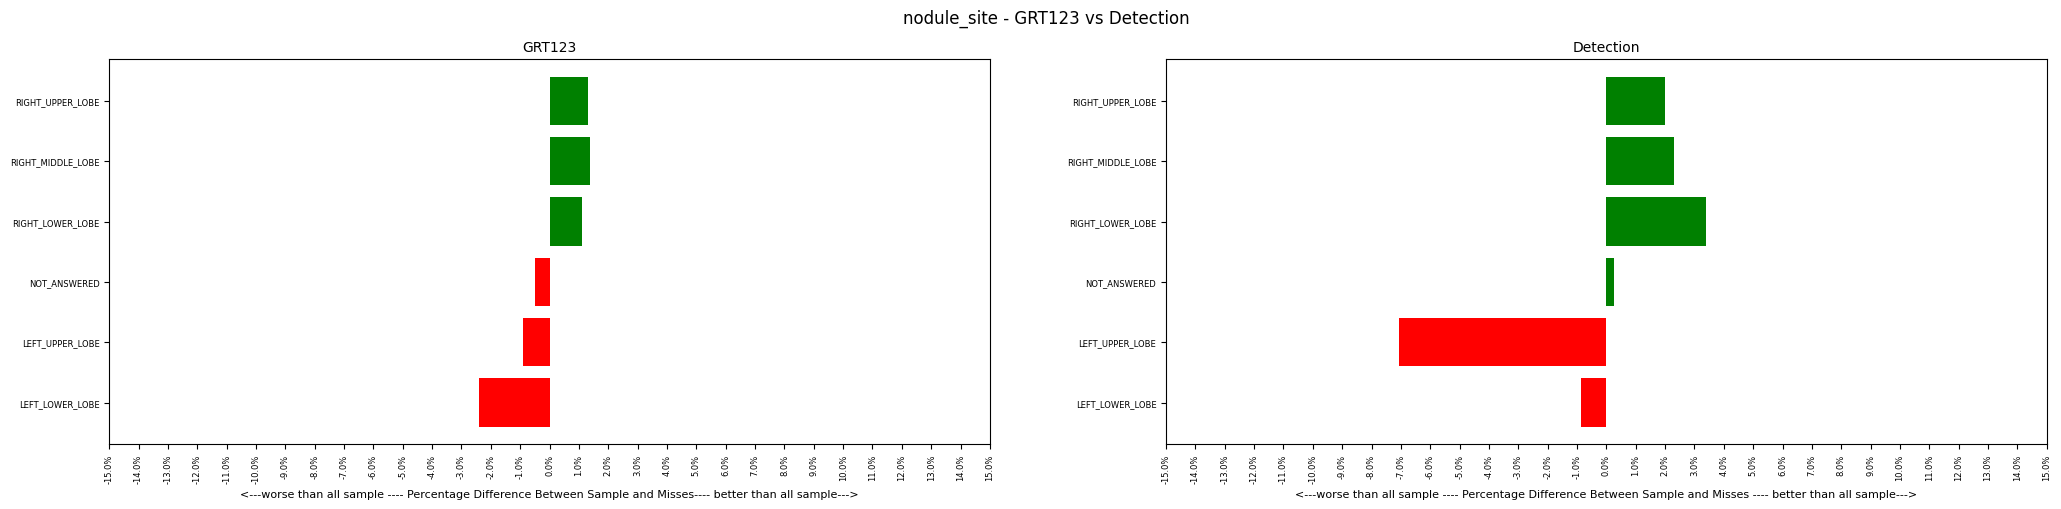

********************************************************************************
management_plan
********************************************************************************


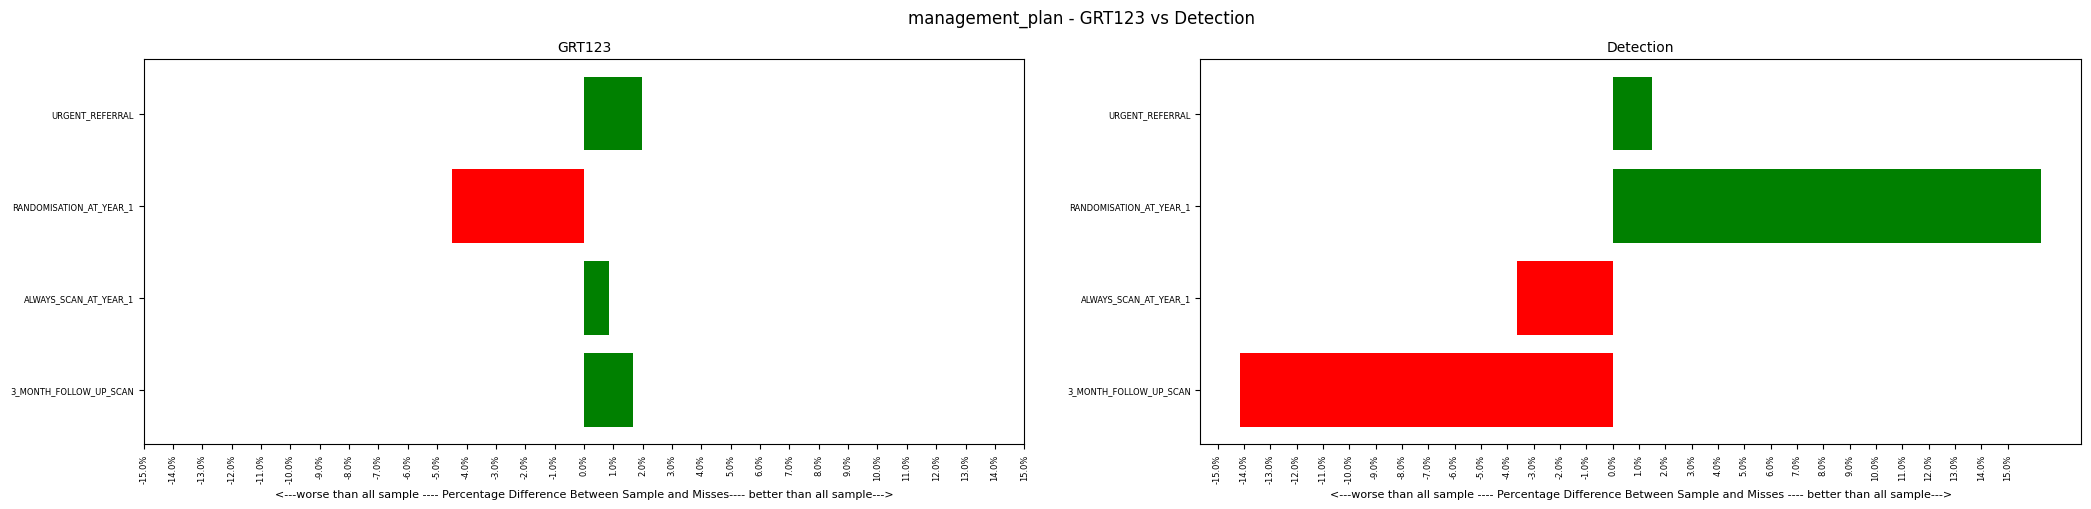

<AxesSubplot:>

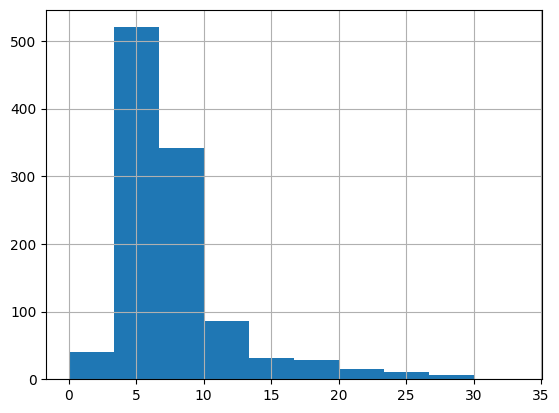

In [71]:
grt123_misses['nodule_diameter_bins'] = pd.cut(grt123_misses.nodule_diameter_mm,
                                        bins=[0, 4, 30, np.inf],
                                        labels=['micro-nodules','nodules','masses']
                                    )

detection_misses['nodule_diameter_bins'] = pd.cut(detection_misses.nodule_diameter_mm,
                                        bins=[0, 4, 30, np.inf],
                                        labels=['micro-nodules','nodules','masses']
                                        )

categorical_variables_to_investigate = ['nodule_type','nodule_lung_rads','nodule_site','management_plan']
for var in categorical_variables_to_investigate:

    print('*'*80)
    print(var)
    print('*'*80)

    x = (
        pd.DataFrame(grt123_misses[var].value_counts(normalize=True)).merge(
        pd.DataFrame(grt123_misses[grt123_misses.miss][var].value_counts(normalize=True)),
        how='outer',
        left_index=True,
        right_index=True,
        suffixes=('_all','_miss')
        ).assign(difference=lambda df: df['proportion'+'_all'] - df['proportion'+'_miss']).applymap(lambda x: f'{x:.2%}')
    ).sort_index()

    y = (
        pd.DataFrame(detection_misses[var].value_counts(normalize=True)).merge(
        pd.DataFrame(detection_misses[detection_misses.miss][var].value_counts(normalize=True)),
        how='outer',
        left_index=True,
        right_index=True,
        suffixes=('_all','_miss')
        ).assign(difference=lambda df: df['proportion'+'_all'] - df['proportion'+'_miss']).applymap(lambda x: f'{x:.2%}')
    ).sort_index()

    fig, ax = plt.subplots(1, 2, figsize=(25,5))

    # Set the color of bars with negative values to red
    ax[0].barh(x.index, x['difference'].str.rstrip('%').astype(float), color=['red' if val < 0 else 'green' for val in x['difference'].str.rstrip('%').astype(float)], label='All')
    ax[1].barh(y.index, y['difference'].str.rstrip('%').astype(float), color=['red' if val < 0 else 'green' for val in y['difference'].str.rstrip('%').astype(float)], label='All')

    # Reduce the font size of the y-axis labels
    ax[0].tick_params(axis='y', labelsize=6)
    ax[1].tick_params(axis='y', labelsize=6)

    ax[0].set_xticks(np.arange(-15,16,1))
    ax[1].set_xticks(np.arange(-15,16,1))

    ax[0].set_xticklabels([f'{x:.1f}%' for x in np.arange(-15,16,1)], fontsize=6, rotation=90)
    ax[1].set_xticklabels([f'{x:.1f}%' for x in np.arange(-15,16,1)], fontsize=6, rotation=90)

    # Add text label below x-axis
    ax[0].set_xlabel('<---worse than all sample ---- Percentage Difference Between Sample and Misses---- better than all sample--->', fontsize=8)
    ax[1].set_xlabel('<---worse than all sample ---- Percentage Difference Between Sample and Misses ---- better than all sample--->', fontsize=8)

    ax[0].set_title('GRT123', fontsize=10)
    ax[1].set_title('Detection', fontsize=10)

    plt.suptitle(f'{var} - GRT123 vs Detection', fontsize=12)
    plt.show()



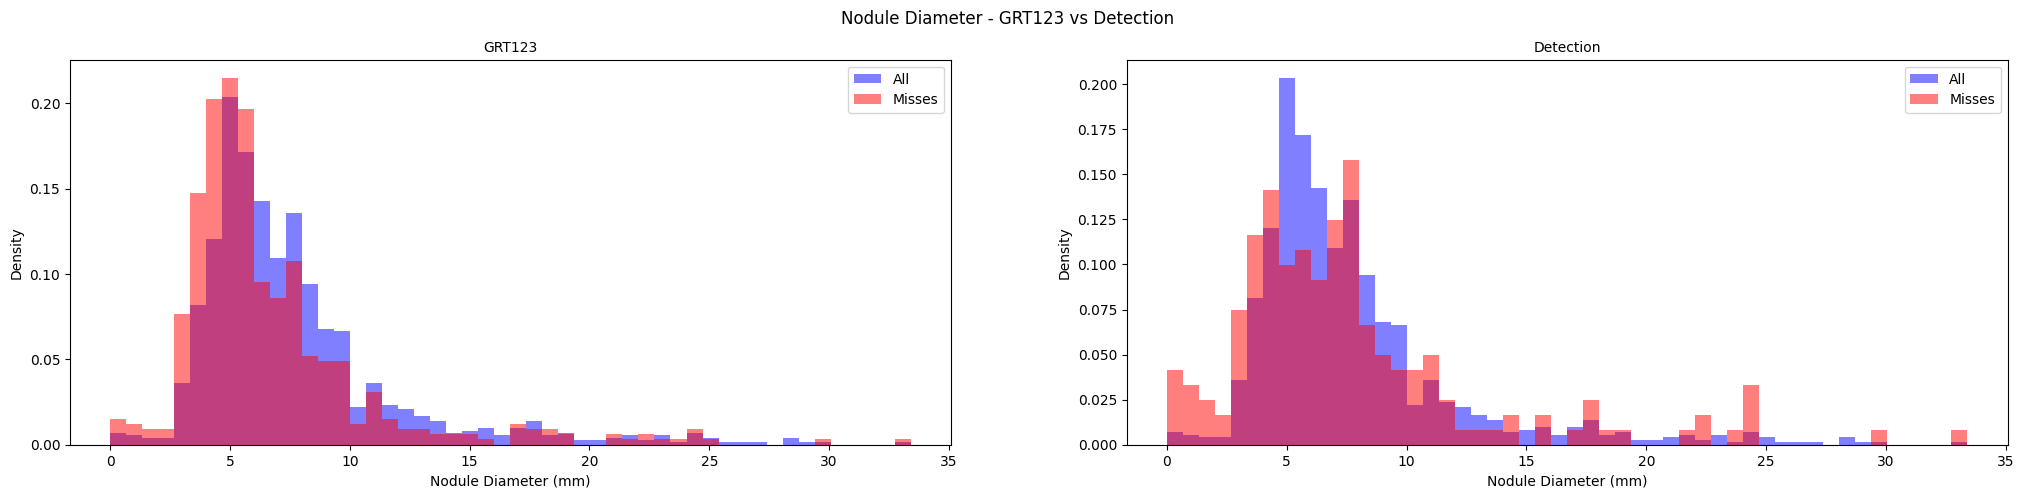

In [76]:

fig, ax = plt.subplots(1, 2, figsize=(25,5))

ax[0].hist(grt123_misses.nodule_diameter_mm, bins=50, color='blue', density=True, alpha=0.5, label='All')
ax[0].hist(grt123_misses[grt123_misses.miss].nodule_diameter_mm, bins=50, color='red', density=True, alpha=0.5, label='Misses')

ax[1].hist(detection_misses.nodule_diameter_mm, bins=50, color='blue', density=True, alpha=0.5, label='All')
ax[1].hist(detection_misses[detection_misses.miss].nodule_diameter_mm, bins=50, color='red', density=True, alpha=0.5, label='Misses')

ax[0].set_title('GRT123', fontsize=10)
ax[1].set_title('Detection', fontsize=10)

ax[0].set_xlabel('Nodule Diameter (mm)')
ax[1].set_xlabel('Nodule Diameter (mm)')

ax[0].set_ylabel('Density')
ax[1].set_ylabel('Density')

ax[0].legend()
ax[1].legend()

plt.suptitle('Nodule Diameter - GRT123 vs Detection', fontsize=12)
plt.show()


Text(0.5, 0.98, 'Nodule Diameter - GRT123 vs Detection')

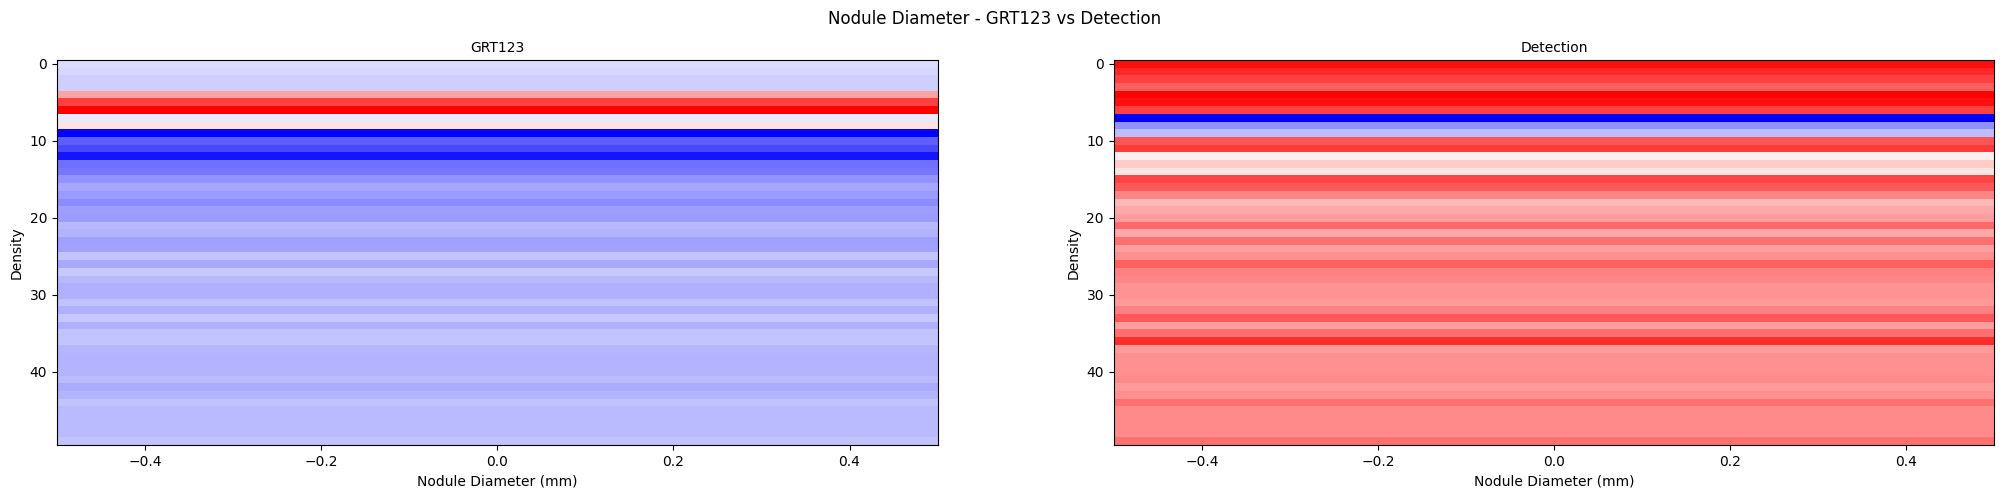

In [92]:
grt123_all_counts, bins  = np.histogram(grt123_misses.nodule_diameter_mm, bins=50, density=True)
grt123_miss_counts, _ = np.histogram(grt123_misses[grt123_misses.miss].nodule_diameter_mm, bins=bins, density=True)

grt123_diameter_hist = pd.DataFrame({'diameter':bins[:-1], 'all':grt123_all_counts, 'miss':grt123_miss_counts}).assign(difference=lambda df: df['all'] - df['miss'])

detection_all_counts, bins  = np.histogram(detection_misses.nodule_diameter_mm, bins=50, density=True)
detection_miss_counts, _ = np.histogram(detection_misses[detection_misses.miss].nodule_diameter_mm, bins=50, density=True)

detect_diameter_hist = pd.DataFrame({'diameter':bins[:-1], 'all':detection_all_counts, 'miss':detection_miss_counts}).assign(difference=lambda df: df['all'] - df['miss'])

fig, ax = plt.subplots(1, 2, figsize=(25,5))

ax[0].imshow(grt123_diameter_hist[['difference']], cmap=cmap, aspect='auto')
ax[1].imshow(detect_diameter_hist[['difference']], cmap=cmap, aspect='auto')

ax[0].set_title('GRT123', fontsize=10)
ax[1].set_title('Detection', fontsize=10)

ax[0].set_xlabel('Nodule Diameter (mm)')
ax[1].set_xlabel('Nodule Diameter (mm)')

ax[0].set_ylabel('Density')
ax[1].set_ylabel('Density')

plt.suptitle('Nodule Diameter - GRT123 vs Detection', fontsize=12)



In [65]:
# How many consolidation nodules are malignant

metadata = pd.concat(pd.read_csv(md_path)
    for md_path in Path(f'{workspace_path}/metadata/summit/partial').rglob('*_metadata.csv')
    if md_path.stem.find('scans_metadata') == -1
)


pd.crosstab(metadata.nodule_type, metadata.radiology_report_malignancy_diagnosis, margins=True, margins_name='Total')



radiology_report_malignancy_diagnosis,LUNG_AND_OTHER_CANCER,LUNG_CANCER_DIAGNOSED_OUTSIDE_OF_SUMMIT_NCRAS,LUNG_CANCER_ONLY,Total
nodule_type,,,,
CALCIFIED,0,0,10,10
NON_SOLID,0,4,13,17
PART_SOLID,1,3,53,57
PERIFISSURAL,0,0,3,3
SOLID,3,2,136,141
Total,4,9,215,228
